(filter-design)=
# Filter Design and Analysis

In [1]:
%run ../setup.ipynb

In the previous section, we saw first how the frequency domain view of convolutional filters lets us reason about their effects.
We then saw that the ideal low-pass filter produced some less-than-ideal results when applied to real signals, notably ringing artifacts which arise from using finite-length approximations to the ideal filter.

In this section, we'll develop this idea further, and see how to construct better convolutional filters.

## Terminology

Before we go further into filter design, it will help to establish some terminology.

For a low-pass filter with cutoff $f_c$, the **pass band** is the set of frequencies $0 \leq f \leq f_c$ that pass through the filter.

The set of frequencies which are blocked by the filter is referred to as the **stop band**.

In general, there is a region between the pass and stop bands where frequencies are attenuated, but still audible, which is known as the **transition band**.

These regions are illustrated below for an example filter in {numref}`freqresponse`.

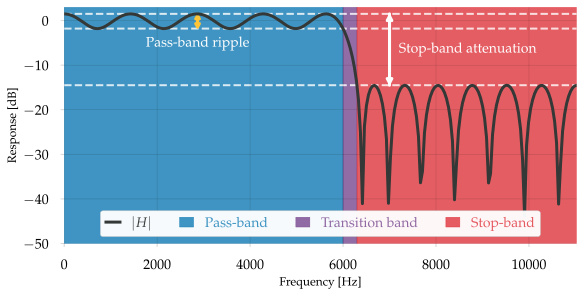

In [396]:
fig, ax = plt.subplots(figsize=figaspect(0.5))

h = scipy.signal.remez(33, [0, 6000, 6300, 11025], [1, 0], fs=22050)
H = np.fft.rfft(h, n=512)
freq = np.fft.rfftfreq(512, 1/22050)
logH = 20 * np.log10(np.abs(H) + 1e-4)

peak = np.max(logH)
atten = np.max(logH[freq > 6300])
ripple = np.min(logH[freq < 6000])

ax.plot(freq, logH, label='$|H|$', color=colors[3], linewidth=3)
ax.set(xlabel='Frequency [Hz]', ylabel='Response [dB]')
ax.axvspan(0, 6000, zorder=-10, color=colors[0], label='Pass-band', alpha=0.75)
ax.axvspan(6000, 6300, zorder=-10, color=colors[4], label='Transition band', alpha=0.75)
ax.axvspan(6300, 11025, zorder=-10, color=colors[1], label='Stop-band', alpha=0.75)
ax.axhline(peak, linestyle='--', color='w', alpha=0.8, zorder=-1, linewidth=2)
ax.axhline(atten, linestyle='--', color='w', alpha=0.8, zorder=-1, linewidth=2)
ax.axhline(ripple, linestyle='--', color='w', alpha=0.8, zorder=-1, linewidth=2)

ax.arrow(7000, peak, 0, atten, color='w', linewidth=3, head_length=1, head_width=100)
ax.arrow(7000, atten, 0, -atten, color='w', linewidth=3, head_length=1, head_width=100)
ax.text(7200, (peak + atten)/2, 'Stop-band attenuation', color='w', va='center')

ax.arrow(2870, peak, 0, ripple, color=colors[2], linewidth=3, head_length=0.75, head_width=80, head_starts_at_zero=True)
ax.arrow(2870, ripple, 0, -ripple, color=colors[2], linewidth=3, head_length=0.75, head_width=80, head_starts_at_zero=True)
ax.text(2870, 2 * ripple, 'Pass-band ripple', color='w', ha='center', va='top')

ax.legend(loc='lower center', labelcolor='linecolor', ncol=4)
ax.set(ylim=[-50, 3])
glue('freqresponse', fig, display=False)

```{glue:figure} freqresponse
:name: freqresponse
The *frequency response* plot of a filter $h$ is the magnitude of its DFT $H$.
This filter was designed to have a cutoff of $f_c = 6000$ Hz and a transition band of $300$ Hz.
```

Within the pass-band, a filter may not have perfectly flat response.
The amount of variation within the pass-band (max-min) is known as **pass-band ripple**.
An ideal filter would have 0 pass-band ripple, which amounts to no change in amplitude for passing frequencies.

Similarly, the difference from the peak response of the pass-band to the peak of the stop-band is the **stop-band attenuation**.
This measures how audible the presumably stopped frequencies will be in the output.
An ideal filter would have infinite attenuation, but the filter in {numref}`freqresponse` has only about 16dB, which is well within the range of human hearing.  (This is probably not a very good filter!)

### What makes a good filter?

The diagram above gives us a way to compare different filters.
In general, the desirable properties of a filter are:

1. High stop-band attenuation.  *The filter stops frequencies when it should.*
2. Small pass-band ripple.  *Passing frequencies aren't too distorted.*
3. Narrow transition band.  *The filter efficiently moves from pass to stop behavior.*

These three properties often present a trade-off, and can depend on the order of the filter in complicated ways.
Designing filters isn't easy, but this section will give you some pointers to standard methods.

## The window method

One of the most common approaches to making low-pass filters is known as the *window method*, and it works by applying a window to the impulse response of the ideal low-pass filter.
This is very similar to the approach taken earlier to combat {ref}`spectral leakage <leakage>`, though for a slightly different reason here.
Rather than force the filter to be periodic, windowing here simply forces the filter to depend only on a finite number of samples, and reduces ringing artifacts.

The window method proceeds by first determining the order $K$ of the filter, which is typically an integer $p$ multiple of the cutoff frequency $f_c$ (measured in samples):

```{math}
K = \left\lfloor\frac{p \cdot f_s}{f_c}\right\rfloor \quad \left[\text{samples}\right]
```

Next, an ideal LPF is constructed for length $K$ and its impulse response $h$ is computed by the inverse DFT.
Finally, a window $w$ (e.g., Hann) is constructed for length $K$ and multiplied by $h$ to produce the windowed filter:

```{math}
h_w[k] = w[k] \cdot h[k].
```

This process is visually demonstrated by {numref}`window-lpf`.

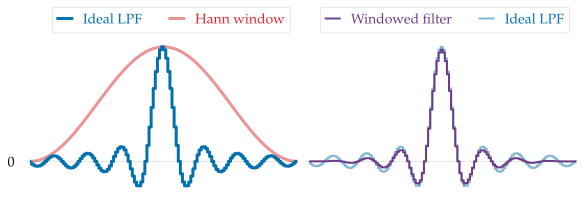

In [413]:
fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=figaspect(1./3))

N = 129
fc = 0.125
h1 = scipy.signal.firwin(N, fc, window='rect')
w1 = scipy.signal.get_window('hann', N, fftbins=False)
h2 = scipy.signal.firwin(N, fc, window='hann')

n = np.arange(N)
ax0.step(n, h1, label='Ideal LPF')
ax0.plot(n, w1 * h1.max(), color=colors[1], label='Hann window', zorder=-1, alpha=0.5)
ax0.legend(loc='lower right', labelcolor='linecolor', ncol=2, bbox_to_anchor=(1,1))

ax1.step(n, h2, label='Windowed filter', color=colors[4], linewidth=2)
ax1.step(n, h1, label='Ideal LPF', zorder=-1, alpha=0.5, linewidth=2)

ax1.legend(loc='lower right', labelcolor='linecolor', ncol=2, bbox_to_anchor=(1,1))
ax0.set(yticks=[0], xticks=[])
glue('window-lpf', fig, display=False)

```{glue:figure} window-lpf
:name: window-lpf

**Left**: the impulse response of an ideal low-pass filter is multiplied by a window function to produce the windowed low-pass filter (**right**).
```

The `scipy` package helpfully implements all of this (and more) for us in one place: `scipy.signal.firwin` (finite impulse response + window).
For example, we could construct a Hann-windowed low-pass filter at $f_c=500$ by the following code:

```{code-block} python
f_cutoff = 500

# Two cycles of the cutoff frequency (in samples)
order = 2 * fs // f_cutoff

# Build the filter
hw = scipy.signal.firwin(order, f_cutoff, window='hann', fs=fs)

# Apply the filter to a signal
y = scipy.signal.convolve(x, hw)
```

The examples below demonstrate this process for Hann-windowed filters with $p=1,2,$ and $4$ cycles of the cutoff frequency, and the filters are visualized in {numref}`firwin`.

In [419]:
import soundfile as sf
from IPython.display import Audio, display

# https://freesound.org/s/517633
x, fs = sf.read('517633__samuelgremaud__slide-whistle-1-mono.wav')
N = len(x)

# Define the cutoff frequency
f_cutoff = 500

In [434]:
# Make the filter long enough to catch two cycles of our cutoff frequency
order1 = 2 * fs // f_cutoff
hw1 = scipy.signal.firwin(order1, f_cutoff, window='hann', fs=fs)
y_hw1 = scipy.signal.convolve(x, hw1, mode='same')

# Or four cycles
order2 = 4 * fs // f_cutoff
hw2 = scipy.signal.firwin(order2, f_cutoff, window='hann', fs=fs)
y_hw2 = scipy.signal.convolve(x, hw2, mode='same')

# Or 8 cycles
order3 = 8 * fs // f_cutoff
hw3 = scipy.signal.firwin(order3, f_cutoff, window='hann', fs=fs)
y_hw3 = scipy.signal.convolve(x, hw3, mode='same')

# Or 16 cycles
order4 = 16 * fs // f_cutoff
hw4 = scipy.signal.firwin(order4, f_cutoff, window='hann', fs=fs)
y_hw4 = scipy.signal.convolve(x, hw4, mode='same')

display(f'Hann-windowed low-pass filter, order={order1}')
display(Audio(data=y_hw1, rate=fs))
display(f'Hann-windowed low-pass filter, order={order2}')
display(Audio(data=y_hw2, rate=fs))
display(f'Hann-windowed low-pass filter, order={order3}')
display(Audio(data=y_hw3, rate=fs))
display(f'Hann-windowed low-pass filter, order={order4}')
display(Audio(data=y_hw4, rate=fs))

'Hann-windowed low-pass filter, order=88'

'Hann-windowed low-pass filter, order=176'

'Hann-windowed low-pass filter, order=352'

'Hann-windowed low-pass filter, order=705'

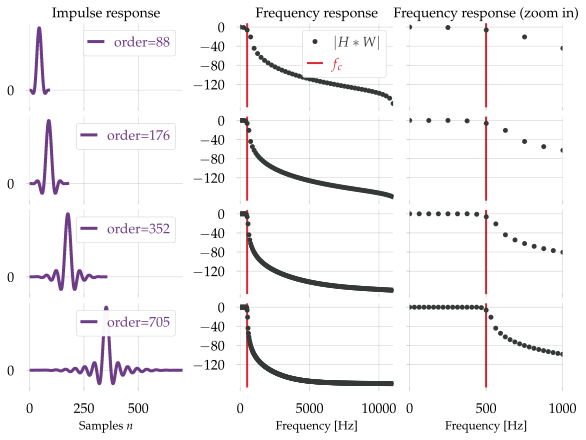

In [435]:
fig, axes = plt.subplots(nrows=4, ncols=3, sharex='col', sharey='col', figsize=figaspect(0.75))

axes[0, 0].step(np.arange(len(hw1)), hw1, where='post', color=colors[4], label=f'order={order1}')
axes[1, 0].step(np.arange(len(hw2)), hw2, where='post', color=colors[4], label=f'order={order2}')
axes[2, 0].step(np.arange(len(hw3)), hw3, where='post', color=colors[4], label=f'order={order3}')
axes[3, 0].step(np.arange(len(hw4)), hw4, where='post', color=colors[4], label=f'order={order4}')
axes[0, 0].legend(loc='upper right', labelcolor='linecolor')
axes[1, 0].legend(loc='upper right', labelcolor='linecolor')
axes[2, 0].legend(loc='upper right', labelcolor='linecolor')
axes[3, 0].legend(loc='upper right', labelcolor='linecolor')
axes[0, 0].set(title='Impulse response')
axes[3, 0].set(xlabel='Samples $n$')
axes[0, 0].set(yticks=[0])

f1 = np.fft.rfftfreq(len(hw1), 1/fs)
f2 = np.fft.rfftfreq(len(hw2), 1/fs)
f3 = np.fft.rfftfreq(len(hw3), 1/fs)
f4 = np.fft.rfftfreq(len(hw4), 1/fs)
axes[0, 1].plot(f1, 20 * np.log10(np.abs(np.fft.rfft(hw1)) + 1e-8), color=colors[3], marker='.', linestyle='', label='$|H*W|$')
axes[1, 1].plot(f2, 20 * np.log10(np.abs(np.fft.rfft(hw2)) + 1e-8), color=colors[3], marker='.', linestyle='')
axes[2, 1].plot(f3, 20 * np.log10(np.abs(np.fft.rfft(hw3)) + 1e-8), color=colors[3], marker='.', linestyle='')
axes[3, 1].plot(f4, 20 * np.log10(np.abs(np.fft.rfft(hw4)) + 1e-8), color=colors[3], marker='.', linestyle='')

axes[0, 1].axvline(f_cutoff, zorder=-1, color=colors[1], label='$f_c$', linewidth=2)
axes[1, 1].axvline(f_cutoff, zorder=-1, color=colors[1], linewidth=2)
axes[2, 1].axvline(f_cutoff, zorder=-1, color=colors[1], linewidth=2)
axes[3, 1].axvline(f_cutoff, zorder=-1, color=colors[1], linewidth=2)
axes[0, 1].legend(loc='upper right', labelcolor='linecolor')
axes[0, 1].set(title='Frequency response')
axes[3, 1].set(xlabel='Frequency [Hz]')

axes[0, 2].plot(f1, 20 * np.log10(np.abs(np.fft.rfft(hw1)) + 1e-8), color=colors[3], marker='.', linestyle='', label='$|H*W|$')
axes[1, 2].plot(f2, 20 * np.log10(np.abs(np.fft.rfft(hw2)) + 1e-8), color=colors[3], marker='.', linestyle='')
axes[2, 2].plot(f3, 20 * np.log10(np.abs(np.fft.rfft(hw3)) + 1e-8), color=colors[3], marker='.', linestyle='')
axes[3, 2].plot(f4, 20 * np.log10(np.abs(np.fft.rfft(hw4)) + 1e-8), color=colors[3], marker='.', linestyle='')
axes[0, 2].axvline(f_cutoff, zorder=-1, color=colors[1], label='$f_c$', linewidth=2)
axes[1, 2].axvline(f_cutoff, zorder=-1, color=colors[1], linewidth=2)
axes[2, 2].axvline(f_cutoff, zorder=-1, color=colors[1], linewidth=2)
axes[3, 2].axvline(f_cutoff, zorder=-1, color=colors[1], linewidth=2)
axes[0, 2].set(title='Frequency response (zoom in)')
axes[3, 2].set(xlabel='Frequency [Hz]')
axes[3, 2].set(xlim=[0, 1000])
axes[0, 2].label_outer()
axes[1, 2].label_outer()
axes[2, 2].label_outer()
axes[3, 2].label_outer()
axes[3, 1].set(yticks=[0, -40, -80, -120])
axes[3, 2].set(yticks=[0, -40, -80, -120])

glue('firwin', fig, display=False)

```{glue:figure} firwin
:name: firwin

**Left**: Hann-windowed low-pass filters for $p=2,4,8,16$ cycles of the cutoff frequency $f_c=500$ (with $f_s=44100$).
**Middle**: the frequency domain representation of the windowed filters (decibel-scaled).
**Right**: a zoomed-in view of the filter DFTs, covering the range $[0, 1000]$.  Note that as the filter length increases, so does the slope of the filter for frequencies above $f_c$.
```

From {numref}`firwin`, we can see that taking longer filters (higher order) results in a better approximation to the ideal LPF, and the output of the filters in each case does not have the ringing artifacts of the ideal LPF.

```{margin}
`scipy.signal.firwin` can do much more than just low-pass filters!

It can directly construct high-pass, band-pass, multi-band filters, and more.
```

When the cutoff frequency $f_c$ is high, the window method can work well.
However, when the cutoff frequency is low (like in this example) this method requires very long filters to achieve narrow transition bands.

(parks-mcclellan)=
## The Parks-McClellan method

The window method is not the only way to create a filter.
Probably the next most commonly used method is due to Parks and McClellan {cite}`parks1972chebyshev`, and it attempts to minimize ripple in both the pass and stop bands.
The algorithm is known alternately as *Parks-McClellan* or *Remez*, the latter after Evgeny Remez, who developed the underlying method to solve the optimization problem several decades earlier {cite}`remez1934determination`.

Unlike the window method, the Parks-McClellan method requires the user to explicitly describe the transition band, and the desired gain in each band (pass and stop).
In Python, this can be done as follows:

```{code-block} python
f_cutoff = 500

# One cycle of the cutoff frequency
order = fs // f_cutoff

# Build the filter using the Remez method
# We'll use the following bands:
#    Pass band: [0, 0.75 * f_cutoff]  (begin to transition at 75% of our cutoff)
#          gain: 1
#    Stop band: [f_cutoff, fs/2]  (attenuate everything above the cutoff)
#          gain: 0

hpm = scipy.signal.remez(order, 
                             [0, 0.75 * f_cutoff, f_cutoff, fs/2],  # Our frequency bands
                             [1, 0],  # Our target gain for each band
                             fs=fs)

# Apply the filter to a signal
y = scipy.signal.convolve(x, hpm)
```

This example starts the transition band before $f_c$, allowing a flat frequency response in the stop band as demonstrated below in {numref}`pmfir`.
The following example outputs demonstrate this filter design applied to our example at multiple orders.
Just as with the window method, higher orders are more precise, but less computationally efficient.

In [422]:
# Make the filter long enough to catch two cycles of our cutoff frequency
order1 = 2 * fs // f_cutoff
hpm1 = scipy.signal.remez(order1, 
                             [0, 0.75 * f_cutoff, 1.0 * f_cutoff, fs/2],
                             [1., 0.0],
                             fs=fs)

y_hpm1 = scipy.signal.convolve(x, hpm1, mode='same')

# Or four cycles
order2 = 4 * fs // f_cutoff
hpm2 = scipy.signal.remez(order2,
                             [0, 0.75 * f_cutoff, 1.0 * f_cutoff, fs/2],
                             [1., 0.0],
                             fs=fs)

y_hpm2 = scipy.signal.convolve(x, hpm2, mode='same')


# Or 8 cycles
order3 = 8 * fs // f_cutoff
hpm3 = scipy.signal.remez(order3,
                             [0, 0.75 * f_cutoff, 1.0 * f_cutoff, fs/2],
                             [1., 0.0],
                             fs=fs)

y_hpm3 = scipy.signal.convolve(x, hpm3, mode='same')


# Or 16 cycles
order4 = 16 * fs // f_cutoff
hpm4 = scipy.signal.remez(order4,
                             [0, 0.75 * f_cutoff, 1.0 * f_cutoff, fs/2],
                             [1., 0.0],
                             fs=fs)

y_hpm4 = scipy.signal.convolve(x, hpm4, mode='same')


# Display the results
display(f'Parks-McClellan filter, order={order1}')
display(Audio(data=y_hpm1, rate=fs))
display(f'Parks-McClellan filter, order={order2}')
display(Audio(data=y_hpm2, rate=fs))
display(f'Parks-McClellan filter, order={order3}')
display(Audio(data=y_hpm3, rate=fs))
display(f'Parks-McClellan filter, order={order4}')
display(Audio(data=y_hpm4, rate=fs))

'Parks-McClellan filter, order=88'

'Parks-McClellan filter, order=176'

'Parks-McClellan filter, order=352'

'Parks-McClellan filter, order=705'

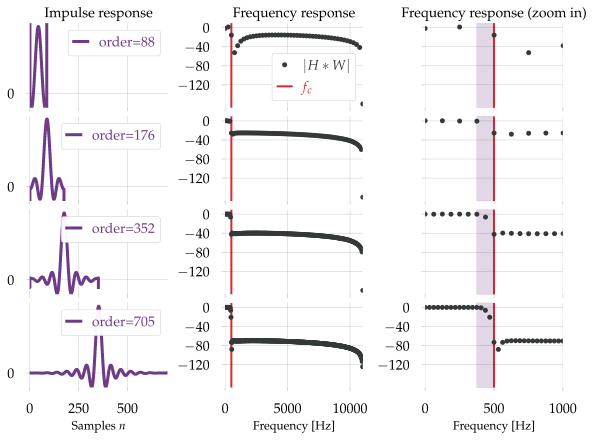

In [423]:
fig, axes = plt.subplots(nrows=4, ncols=3, sharex='col', sharey='col', figsize=figaspect(0.75))

axes[0, 0].step(np.arange(len(hpm1)), hpm1, where='post', color=colors[4], label=f'order={order1}')
axes[1, 0].step(np.arange(len(hpm2)), hpm2, where='post', color=colors[4], label=f'order={order2}')
axes[2, 0].step(np.arange(len(hpm3)), hpm3, where='post', color=colors[4], label=f'order={order3}')
axes[3, 0].step(np.arange(len(hpm4)), hpm4, where='post', color=colors[4], label=f'order={order4}')
axes[0, 0].legend(loc='upper right', labelcolor='linecolor')
axes[1, 0].legend(loc='upper right', labelcolor='linecolor')
axes[2, 0].legend(loc='upper right', labelcolor='linecolor')
axes[3, 0].legend(loc='upper right', labelcolor='linecolor')
axes[3, 0].set(ylim=1.05 * np.array([hpm3.min(), hpm3.max()]))
axes[0, 0].set(title='Impulse response')
axes[3, 0].set(xlabel='Samples $n$')
axes[0, 0].set(yticks=[0])

f1 = np.fft.rfftfreq(len(hpm1), 1/fs)
f2 = np.fft.rfftfreq(len(hpm2), 1/fs)
f3 = np.fft.rfftfreq(len(hpm3), 1/fs)
f4 = np.fft.rfftfreq(len(hpm4), 1/fs)

axes[0, 1].plot(f1, 20 * np.log10(np.abs(np.fft.rfft(hpm1)) + 1e-8), color=colors[3], marker='.', linestyle='', label='$|H*W|$')
axes[1, 1].plot(f2, 20 * np.log10(np.abs(np.fft.rfft(hpm2)) + 1e-8), color=colors[3], marker='.', linestyle='')
axes[2, 1].plot(f3, 20 * np.log10(np.abs(np.fft.rfft(hpm3)) + 1e-8), color=colors[3], marker='.', linestyle='')
axes[3, 1].plot(f4, 20 * np.log10(np.abs(np.fft.rfft(hpm4)) + 1e-8), color=colors[3], marker='.', linestyle='')
axes[0, 1].axvline(f_cutoff, zorder=-1, color=colors[1], label='$f_c$', linewidth=2)
axes[1, 1].axvline(f_cutoff, zorder=-1, color=colors[1], linewidth=2)
axes[2, 1].axvline(f_cutoff, zorder=-1, color=colors[1], linewidth=2)
axes[3, 1].axvline(f_cutoff, zorder=-1, color=colors[1], linewidth=2)
axes[0, 1].legend(loc='lower right', labelcolor='linecolor')
axes[0, 1].set(title='Frequency response')
axes[3, 1].set(xlabel='Frequency [Hz]')

axes[0, 2].plot(f1, 20 * np.log10(np.abs(np.fft.rfft(hpm1)) + 1e-8), color=colors[3], marker='.', linestyle='', label='$|H*W|$')
axes[1, 2].plot(f2, 20 * np.log10(np.abs(np.fft.rfft(hpm2)) + 1e-8), color=colors[3], marker='.', linestyle='')
axes[2, 2].plot(f3, 20 * np.log10(np.abs(np.fft.rfft(hpm3)) + 1e-8), color=colors[3], marker='.', linestyle='')
axes[3, 2].plot(f4, 20 * np.log10(np.abs(np.fft.rfft(hpm4)) + 1e-8), color=colors[3], marker='.', linestyle='')
axes[0, 2].axvline(f_cutoff, zorder=-1, color=colors[1], label='$f_c$', linewidth=2)
axes[1, 2].axvline(f_cutoff, zorder=-1, color=colors[1], linewidth=2)
axes[2, 2].axvline(f_cutoff, zorder=-1, color=colors[1], linewidth=2)
axes[3, 2].axvline(f_cutoff, zorder=-1, color=colors[1], linewidth=2)
axes[0, 2].axvspan(0.75 * 500, 500, color=colors[4], alpha=0.2, zorder=-1)
axes[1, 2].axvspan(0.75 * 500, 500, color=colors[4], alpha=0.2, zorder=-1)
axes[2, 2].axvspan(0.75 * 500, 500, color=colors[4], alpha=0.2, zorder=-1)
axes[3, 2].axvspan(0.75 * 500, 500, color=colors[4], alpha=0.2, zorder=-1)
axes[0, 2].set(title='Frequency response (zoom in)')
axes[3, 2].set(xlabel='Frequency [Hz]')
axes[3, 2].set(xlim=[0, 1000])
axes[0, 2].label_outer()
axes[1, 2].label_outer()
axes[2, 2].label_outer()
axes[3, 1].set(yticks=[0, -40, -80, -120])
axes[3, 2].set(yticks=[0, -40, -80, -120])

glue('pmfir', fig, display=False)

```{glue:figure} pmfir
:name: pmfir

Parks-McClellan filters with transition band $[3/4 \cdot f_c, f_c] = [375, 500]$ Hz (shaded regions) at multiple orders ($p=2,4,8,16$ cycles of $f_c$).
As in {numref}`firwin`, increasing the order improves the attenuation of the filter.
```

Comparing the frequency responses of window-method filters {numref}`firwin` to those of the Parks-McClellan filters {numref}`pmfir`, we can see that the windowed filters have gentler slope, and the Parks-McClellan filters have a steeper transition with a flat response in the stop-band.
Both are effective at suppressing high-frequency content, though neither method will completely eliminate frequencies above $f_c$.
That's okay though --- usually all we care about when filtering is reducing the stop-band energy to the point where it is not perceptible.